# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')

In [3]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

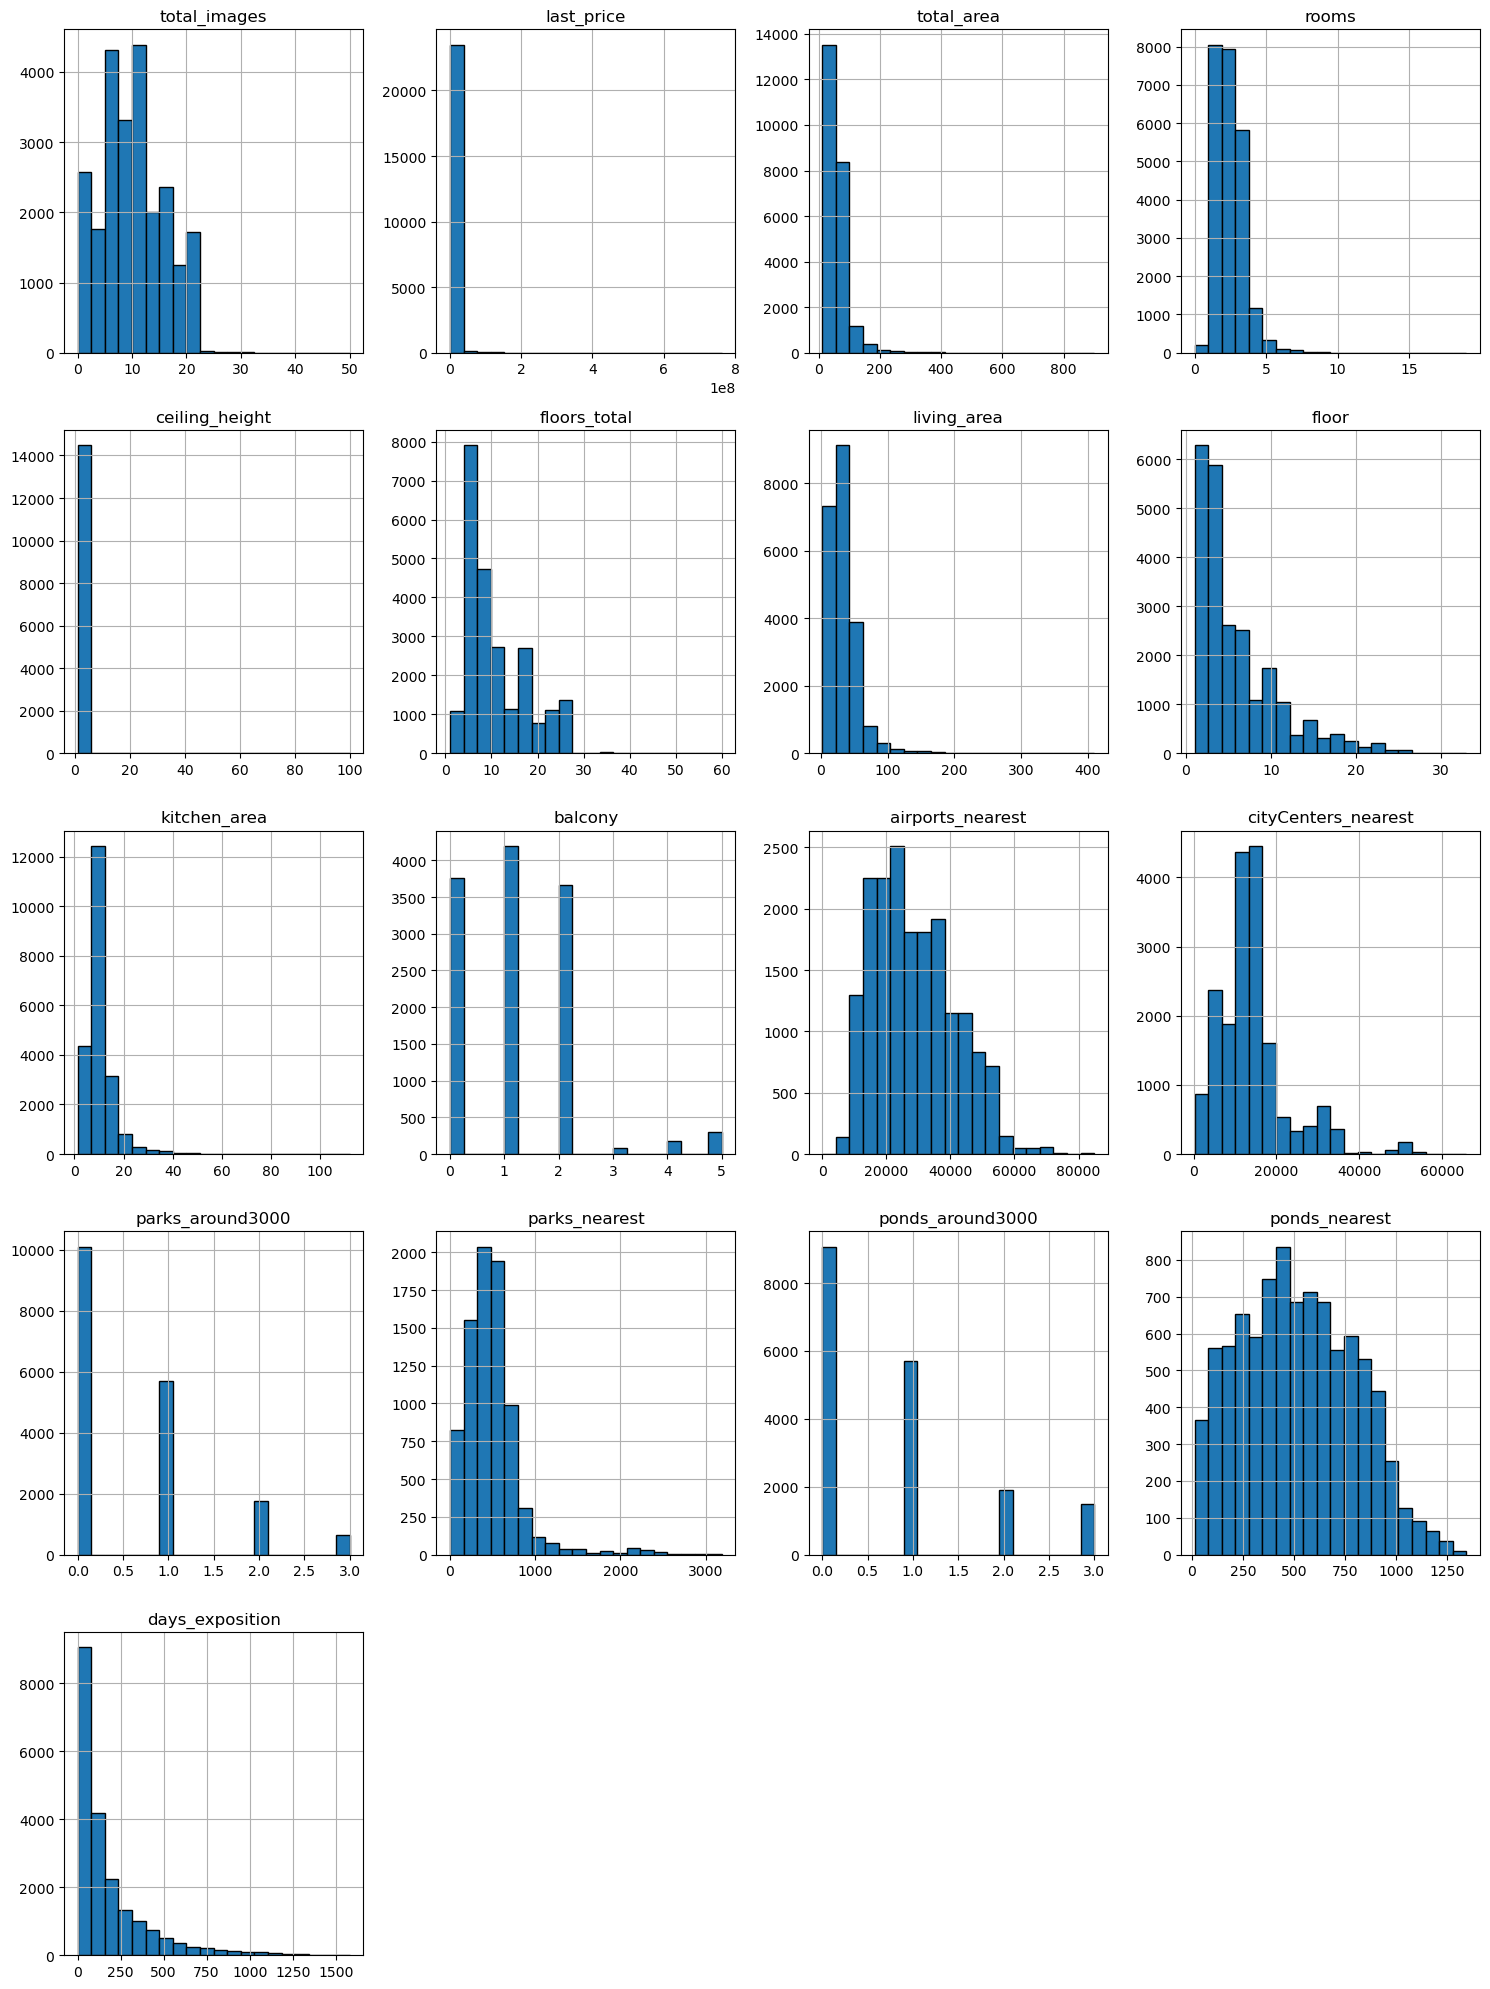

In [5]:
# Построение гистограмм для всех числовых столбцов
data.hist(figsize=(15, 20), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

## Выполним предобработку данных

### Удаление пропусков

Найдем общее количество пропусков по столбцам

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Получили довольно много столбцов с пропусками. <br>
Причины пропусков в данных могут быть разные. В данных, которые заполняли пользователи вручную, могут быть намеренные пропуски из-за нежелания автора отвечать на вопрос или банально незнания ответа. <br>
Пропуски в данных, которые были получены автоматически, могли возникнуть из-за ошибок в геоданных или отсутствия данных для определенных локаций.

Начнем заполнять пропуски постепенно со столбцов, которые заполняют сами пользователи. <br>
Столбец <i>balcony</i> заполним нулями. <br>
Если продавец не указал число балконов, то, скорее всего, в его квартире их нет.

In [7]:
# Заполнение пропусков для столбца balcony
data['balcony'] = data['balcony'].fillna(0)

# Проверка результатов заполнения
data['balcony'].isnull().sum()

0

Аналогичным образом можно заполнить столбец <i> is_apartment </i>. Пропуски в данных можно интерпретировать как <i> False </i>(не апартаменты). 

In [8]:
# Заполнение пропусков для столбца is_apartment
data['is_apartment'] = data['is_apartment'].fillna(False)

# Проверка результатов заполнения
data['is_apartment'].isnull().sum()

0

Столбцы <i> ceiling_height </i>, <i> living_area </i> и <i> kitchen_area </i> могут зависеть от общей площади квартиры (<i>total_area</i>). <br>
Поэтому здесь логично предположить следующих подход: сделаем 5 категорий для квартир по общей площади с помощью квантилей.<br>
В каждой категории посчитаем медианы для нужных столбцов. И заполним пропуски медианами, опираясь на категории. <br>
Заполнение пропусков в числовых данных медианой поможет сохранить общую структуру распределения, а опора на категории по общей площади обеспечит большую "адекватность" заполнения пропусков.


In [9]:
# Создание категорий по площади с помощью квантилей
data['area_category'] = pd.qcut(data['total_area'], 5, labels=False)

# Группировка по категориям площади и расчёт медиан для ceiling_height, living_area, kitchen_area
category_medians = data.groupby('area_category')[['ceiling_height', 'living_area', 'kitchen_area']].median()

# Функция для заполнения пропусков с помощью apply
def fill_missing_values(row, col_name):
    if pd.isna(row[col_name]):
        return category_medians.loc[row['area_category'], col_name]
    return row[col_name]

# Применение функции к каждому из нужных столбцов
data['ceiling_height'] = data.apply(lambda row: fill_missing_values(row, 'ceiling_height'), axis=1)
data['living_area'] = data.apply(lambda row: fill_missing_values(row, 'living_area'), axis=1)
data['kitchen_area'] = data.apply(lambda row: fill_missing_values(row, 'kitchen_area'), axis=1)

# Проверка результатов заполнения
data[['ceiling_height', 'living_area', 'kitchen_area']].isnull().sum()

ceiling_height    0
living_area       0
kitchen_area      0
dtype: int64

Столбец <i> locality_name </i> является категориальным. Поэтому в этом случае не так очевидно, как заполнить пропуски. <br>
С одной стороны, можно все эти строчки просто удалить, поскольку их всего 49 из 23699, это около 0.21% от всех данных. <br> 
С другой стороны, чтобы не удалять эти строчки, можно создать новую категорию, назовём её "unknown". Этот вариант сохранит больше данных, и мы всегда сможем идентифицировать эти строки при дальнейшем анализе.

In [10]:
# Заполнение пропусков в столбце locality_name категорией "unknown"
data['locality_name'] = data['locality_name'].fillna('unknown')

# Проверка результатов заполнения
data['locality_name'].isnull().sum()

0

Столбец <i> floors_total </i> тоже можем заполнить медианными значениями, опираясь на населенные пункты. Это звучит логично, поскольку в конкретном населенном пункте застройка должна быть примерно одинаковой.

In [11]:
# Группировка по locality_name и расчёт медианных значений для floors_total
locality_floors_median = data.groupby('locality_name')['floors_total'].median()

# Заполнение пропусков в floors_total медианными значениями в соответствии с locality_name
data['floors_total'] = data.apply(
    lambda row: locality_floors_median[row['locality_name']] if pd.isna(row['floors_total']) else row['floors_total'],
    axis=1
)

# Проверка результатов заполнения
data['floors_total'].isnull().sum()

0

Теперь перейдем к данным, которые были получены автоматически. <br>
Столбцы <i> parks_around3000 </i> и <i> ponds_around3000 </i> можно по такой же логике, как с балконами, заполнить нулями, предполагая отсутствие парков и водоемов в радиусе. То есть, если данные не были получены автоматически, то, скорее всего, их нет.<br>

In [12]:
# Заполнение пропусков для столбцов parks_around3000 и ponds_around3000 нулями
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

# Проверка результатов после заполнения
data[['parks_around3000', 'ponds_around3000']].isnull().sum()

parks_around3000    0
ponds_around3000    0
dtype: int64

Столбцы <i> airports_nearest </i> и <i> cityCenters_nearest </i> можно заполнить медианным значением по локации. Это логичный вариант, поскольку он уменьшит влияние экстремальных значений и предоставит более реалистичное представление о расстояниях до ближайшего аэропорта или ближайшего центра.

In [13]:
# Группировка по locality_name и расчёт медианных значений для airports_nearest и cityCenters_nearest
locality_distance_median = data.groupby('locality_name')[['airports_nearest', 'cityCenters_nearest']].median()

# Заполнение пропусков в airports_nearest и cityCenters_nearest медианными значениями в соответствии с locality_name
data['airports_nearest'] = data.apply(
    lambda row: locality_distance_median.loc[row['locality_name'], 'airports_nearest']
    if pd.isna(row['airports_nearest']) else row['airports_nearest'], axis=1
)
data['cityCenters_nearest'] = data.apply(
    lambda row: locality_distance_median.loc[row['locality_name'], 'cityCenters_nearest']
    if pd.isna(row['cityCenters_nearest']) else row['cityCenters_nearest'], axis=1
)

# Проверка результатов заполнения для airports_nearest и cityCenters_nearest
data[['airports_nearest', 'cityCenters_nearest']].isnull().sum()

airports_nearest       5386
cityCenters_nearest    5386
dtype: int64

В столбцах остались пропуски, по 5386 в каждом. Это может быть связано с тем, что для некоторых населённых пунктов нет ни одного заполненного значения, то есть мы просто не можем посчитать медиану. <br> 
Лучше эти пропуски оставить как есть, чтобы не искажать представление о данных. 

Столбцы <i> parks_nearest </i> и <i> ponds_nearest </i> можно заполнить медианным значением по населенным пунктам.  

In [14]:
# Расчёт медианных значений для parks_nearest и ponds_nearest по населённым пунктам
parks_median = data.groupby('locality_name')['parks_nearest'].median()
ponds_median = data.groupby('locality_name')['ponds_nearest'].median()

# Заполнение пропусков в parks_nearest и ponds_nearest медианными значениями в соответствии с locality_name
data['parks_nearest'] = data.apply(
    lambda row: parks_median.loc[row['locality_name']] if pd.isna(row['parks_nearest']) and row['locality_name'] in parks_median.index else row['parks_nearest'],
    axis=1
)
data['ponds_nearest'] = data.apply(
    lambda row: ponds_median.loc[row['locality_name']] if pd.isna(row['ponds_nearest']) and row['locality_name'] in ponds_median.index else row['ponds_nearest'],
    axis=1
)

# Проверка количества оставшихся пропусков в parks_nearest и ponds_nearest
data[['parks_nearest', 'ponds_nearest']].isnull().sum()

parks_nearest    5998
ponds_nearest    5494
dtype: int64

Пропуски в столбцах остались, но их стало гораздо меньше. <br>
Скорее всего, логичнее оставить эти пропуски, как есть, поскольку в дальнейшем анализе они будут указывать на отсутствие парка или водоема в доступной близости. <br> 
В этом случае не стоит делать медиану по всему столбцу для оставшихся пропусков, как со столбцами <i> airports_nearest </i> и <i> cityCenters_nearest</i>, поскольку парков и водоёмов может быть на порядок больше, чем, например, аэропортов.

Остался столбец <i>days_exposition</i> - сколько дней было размещено объявление (от публикации до снятия).
Пропуски в нем могут означать, что объявление еще не было снято с публикации на момент сбора данных. Это делает проблематичным подсчет активного количества дней у таких объявлений. <br> 
Поэтому логично оставить эти пропуски как есть. Это будет означать, что анализируемое объявление ещё активно.

Проверим пропуски во всех столбцах.

In [15]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        5386
cityCenters_nearest     5386
parks_around3000           0
parks_nearest           5998
ponds_around3000           0
ponds_nearest           5494
days_exposition         3181
area_category              0
dtype: int64

Таким образом, мы заполнили пропуски почти во всех столбцах, используя различную логику. <br>
Пропуски остались в столбцах <i> parks_nearest </i> и <i>ponds_nearest</i>. Это будет означать, что эти объекты находятся далеко от квартиры.<br>
Аналогично со столбцами <i> airports_nearest</i> и <i>cityCenters_nearest </i>. <br>
А так же пропуски остались в столбце <i>days_exposition</i>. Это означает, что 3181 объявлений ещё активны на момент сбора данных и нашего анализа.

### Обработка типов данных

Рассмотрим ещё раз типы данных в каждом столбце

In [16]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
area_category             int64
dtype: object

Столбцы, у которых нужно поменять тип данных:<br>
<i>first_day_exposition</i> - необходимо сделать временной тип. <br>
<i>floors_total, balcony, parks_around3000, ponds_around3000</i> можно сделать эти столбцы целочисленными, какие они и есть по смыслу. <br>
Столбец <i> days_exposition</i> тоже по смыслу целочисленный, но в нем есть пропуски. Поэтому его обработаем специальным образом.

In [17]:
# Приведение столбца first_day_exposition к типу datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

In [18]:
# Приведение столбцов floors_total, balcony, parks_around3000, ponds_around3000 к целочисленному типу
columns_to_convert = ['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']
data[columns_to_convert] = data[columns_to_convert].astype(int)

In [19]:
# Приведение столбца days_exposition к типу Int64, т.к. он поддерживает пропуски
data['days_exposition'] = np.floor(pd.to_numeric(data['days_exposition'], errors='coerce')).astype('Int64')

Проверим типы данных столбцов

In [20]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000                 int64
parks_nearest                  float64
ponds_around3000                 int64
ponds_nearest                  float64
days_exposition                  Int64
area_category                    int64
dtype: object

In [21]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>,4
1,7,3350000.0,40.4,2018-12-04,1,2.60,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,584.5,81,1
2,10,5196000.0,56.0,2015-08-20,2,2.60,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,2
3,0,64900000.0,159.0,2015-07-24,3,2.90,14,55.0,9,False,False,False,14.0,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,4
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,4


Теперь все типы данных кажутся корректными. Можно двигаться дальше.

### Изучение уникальных значений <i> locality_name </i>

Рассмотрим все уникальные значения в столбце <i> locality_name </i>

In [22]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Немного улучшим данные визуально. Приведем всё к нижнему регистру и отсортируем. Будем это делать в новом столбце <i> unique_locality_name</i>, чтобы была возможность посмотреть на исходное название.

In [23]:
# Приведение всех значений в столбце `unique_locality_name` к нижнему регистру 
data['unique_locality_name'] = data['locality_name'].str.lower()

# Сортировка и вывод уникальных значений
data['unique_locality_name'].sort_values().unique()

array(['unknown', 'бокситогорск', 'волосово', 'волхов', 'всеволожск',
       'выборг', 'высоцк', 'гатчина', 'городской поселок большая ижора',
       'городской поселок янино-1', 'городской посёлок будогощь',
       'городской посёлок виллози', 'городской посёлок лесогорский',
       'городской посёлок мга', 'городской посёлок назия',
       'городской посёлок новоселье', 'городской посёлок павлово',
       'городской посёлок рощино', 'городской посёлок свирьстрой',
       'городской посёлок советский', 'городской посёлок фёдоровское',
       'городской посёлок янино-1', 'деревня агалатово', 'деревня аро',
       'деревня батово', 'деревня бегуницы', 'деревня белогорка',
       'деревня большая вруда', 'деревня большая пустомержа',
       'деревня большие колпаны', 'деревня большое рейзино',
       'деревня большой сабск', 'деревня бор', 'деревня борисова грива',
       'деревня ваганово', 'деревня вартемяги', 'деревня вахнова кара',
       'деревня выскатка', 'деревня гарболово', 'дер

Данных очень много, поэтому нужно придумать универсальное решение. <br> 
Во-первых, букву "ё" мы заменим на "е" для удобства. <br> 
Во-вторых, можно убрать слова "деревня", "городской поселок", "поселок городского типа", чтобы остались только уникальные названия.<br>
Так мы сможем выявить все уникальные значения столбца <i>locality_name</i>.

In [24]:
# Замена "ё" на "е" в столбце unique_locality_name
data['unique_locality_name'] = data['unique_locality_name'].str.replace('ё', 'е')

# Удаление общих обозначений населённых пунктов
patterns = ['деревня', 'городской поселок', 'поселок городского типа', 'поселок','коттеджный поселок','село', 'город', 'садовое товарищество']
for pattern in patterns:
    data['unique_locality_name'] = data['unique_locality_name'].str.replace(pattern, '')

# Удаление лишних пробелов после фильтрации
data['unique_locality_name'] = data['unique_locality_name'].str.strip()

# Проверка уникальных значений
data['unique_locality_name'].sort_values().unique()

array(['unknown', 'агалатово', 'александровская', 'алексеевка', 'аннино',
       'аро', 'барышево', 'батово', 'бегуницы', 'белогорка', 'белоостров',
       'бокситогорск', 'большая вруда', 'большая ижора',
       'большая пустомержа', 'большие колпаны', 'большое рейзино',
       'большой сабск', 'бор', 'борисова грива', 'бугры', 'будогощь',
       'ваганово', 'важины', 'вартемяги', 'вахнова кара', 'виллози',
       'вознесенье', 'возрождение', 'войсковицы', 'войскорово',
       'володарское', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'вырица', 'выскатка', 'высокоключевой', 'высоцк', 'гаврилово',
       'гарболово', 'гатчина', 'гладкое', 'глажево', 'глебычево',
       'глинка', 'гончарово', 'горбунки', 'гостилицы', 'громово',
       'дзержинского', 'дружная горка', 'дружноселье', 'дубровка',
       'елизаветино', 'ефимовский', 'жил', 'жилок', 'житково',
       'заводской', 'заклинье', 'заневка', 'запорожское', 'зеленогорск',
       'зимитицы', 'иван', 'извара', 'ильичево', 'и

Теперь в столбце unique_locality_name будут храниться уникальные значения.

In [25]:
data.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.3,3,False,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,<NA>,4,санкт-петербург
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.0,4,False,False,False,8.50,0,Тосно,NaN,NaN,0,NaN,0,NaN,45,3,тосно
23696,18,2500000.0,56.70,2018-02-11,2,2.60,3,29.7,1,False,False,False,8.40,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,<NA>,2,рождествено
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,55.0,12,False,False,False,23.30,2,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602,4,санкт-петербург
23698,4,1350000.0,32.30,2017-07-21,1,2.50,5,12.3,1,False,False,False,9.00,0,поселок Новый Учхоз,NaN,NaN,0,NaN,0,NaN,<NA>,0,новый учхоз


Таким образом, мы создали новый столбец <i>unique_locality_name</i>, по которому мы сможем идентифицировать уникальное значение столбца <i> locality_name</i>. А так же мы всегда сможем обратиться к исходному названию.

Блок по предобработке данных завершен. 
<br> <br>
Мы нашли и заполнили большинство пропущенных значений в столбцах. <br>
Пропуски остались в столбцах <i> parks_nearest </i> и <i>ponds_nearest</i>. Это будет означать, что эти объекты находятся далеко от квартиры. Аналогично со столбцами <i> airports_nearest</i> и <i>cityCenters_nearest </i>. <br>
А так же пропуски остались в столбце <i>days_exposition</i>. Это означает, что 3181 объявлений ещё активны на момент сбора данных и нашего анализа. 
<br> <br>
Рассмотрели типы данных в каждом столбце и изменили их там, где было нужно.
<br> <br>
Создали новый столбец <i>unique_locality_name</i>, по которому мы сможем идентифицировать уникальное значение столбца <i> locality_name</i>.

## Добавим в таблицу новые столбцы

Будем добавлять столбцы постепенно.

### Цена одного квадратного метра

Нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой.

In [26]:
# Расчет цены за квадратный метр и добавление в новый столбец
data['price_per_sqm'] = (data['last_price'] / data['total_area']).round(2)

# Просмотр первых строк таблицы для проверки нового столбца
print(data[['last_price', 'total_area', 'price_per_sqm']].head())

   last_price  total_area  price_per_sqm
0  13000000.0       108.0      120370.37
1   3350000.0        40.4       82920.79
2   5196000.0        56.0       92785.71
3  64900000.0       159.0      408176.10
4  10000000.0       100.0      100000.00


### День недели публикации объявления 

0 — понедельник, 1 — вторник и так далее.

In [27]:
# Получение дня недели публикации объявления
data['weekday_published'] = data['first_day_exposition'].dt.dayofweek

### Месяц публикации объявления

In [28]:
# Получение месяца публикации объявления
data['month_published'] = data['first_day_exposition'].dt.month

### Год публикации объявления

In [29]:
# Получение года публикации объявления
data['year_published'] = data['first_day_exposition'].dt.year

# Просмотр первых строк таблицы для проверки новых столбцов
print(data[['first_day_exposition', 'weekday_published', 'month_published', 'year_published']].head())

  first_day_exposition  weekday_published  month_published  year_published
0           2019-03-07                  3                3            2019
1           2018-12-04                  1               12            2018
2           2015-08-20                  3                8            2015
3           2015-07-24                  4                7            2015
4           2018-06-19                  1                6            2018


### Тип этажа квартиры 

Значения — «первый», «последний», «другой».

In [30]:
# Функция для определения типа этажа
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

# Применение функции и создание нового столбца
data['floor_type'] = data.apply(floor_type, axis=1)

# Просмотр первых строк таблицы для проверки нового столбца
print(data[['floor', 'floors_total', 'floor_type']].head())

   floor  floors_total floor_type
0      8            16     другой
1      1            11     первый
2      4             5     другой
3      9            14     другой
4     13            14     другой


### Расстояние до центра города в километрах 

Переведём из метров в километры и округлим до ближайших целых значений.

In [31]:
# Преобразование расстояния из метров в километры и округление
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()

# Приведение столбца cityCenters_nearest_km к типу Int64, т.к. он поддерживает пропуски
data['cityCenters_nearest_km'] = np.floor(pd.to_numeric(data['cityCenters_nearest_km'], errors='coerce')).astype('Int64')

# Просмотр первых строк таблицы для проверки нового столбца
print(data[['cityCenters_nearest', 'cityCenters_nearest_km']].head())

   cityCenters_nearest  cityCenters_nearest_km
0              16028.0                      16
1              18603.0                      19
2              13933.0                      14
3               6800.0                       7
4               8098.0                       8


Теперь посмотрим на первые строчки датасета, чтобы убедиться, что мы всё правильно сделали.

In [32]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>,4,санкт-петербург,120370.37,3,3,2019,другой,16
1,7,3350000.0,40.40,2018-12-04,1,2.60,11,18.60,1,False,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,584.5,81,1,шушары,82920.79,1,12,2018,первый,19
2,10,5196000.0,56.00,2015-08-20,2,2.60,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,2,санкт-петербург,92785.71,3,8,2015,другой,14
3,0,64900000.0,159.00,2015-07-24,3,2.90,14,55.00,9,False,False,False,14.00,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,4,санкт-петербург,408176.10,4,7,2015,другой,7
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,4,санкт-петербург,100000.00,1,6,2018,другой,8
5,10,2890000.0,30.40,2018-09-10,1,2.58,12,14.40,5,False,False,False,9.10,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55,0,янино-1,95065.79,0,9,2018,другой,<NA>
6,6,3700000.0,37.30,2017-11-02,1,2.58,26,10.60,6,False,False,False,14.40,1,посёлок Парголово,52996.0,19143.0,0,733.0,0,593.0,155,0,парголово,99195.71,3,11,2017,другой,19
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,40.00,22,False,False,False,18.90,2,Санкт-Петербург,23982.0,11634.0,0,460.0,0,503.0,<NA>,3,санкт-петербург,110544.69,3,4,2019,другой,12
8,20,2900000.0,33.16,2018-05-23,1,2.58,27,15.43,26,False,False,False,8.81,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,189,0,мурино,87454.76,2,5,2018,другой,<NA>
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.60,7,False,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0,460.0,0,503.0,289,3,санкт-петербург,88524.59,6,2,2017,другой,15


В этом блоке мы создали 6 новых столбцов, которые помогут нам в дальнейшем анализе.

## Проведем исследовательский анализ данных

### Изучение параметров

Будем изучать параметры по очереди. 

#### Общая площадь

In [33]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

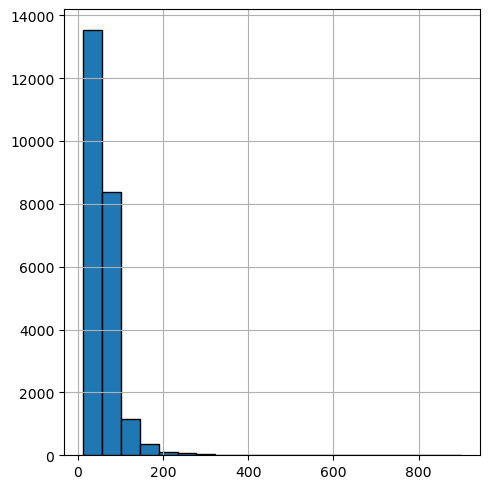

In [34]:
# Построение гистограммы для общей площади 
data['total_area'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

В выборке встречаются аномально большие значения общей площади. <br>
Основываясь на статье https://lenta.ru/news/2019/08/15/spb/, возьмем за максимальную общую площадь значение 539 кв.м. <br>
Посмотрим, сколько в данных квартир с площадью больше 539 квадратных метров.

In [35]:
data.query('total_area > 539')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km
3117,19,140000000.0,631.0,2019-03-30,7,2.9,5,55.0,5,False,False,False,60.0,0,Санкт-Петербург,25707.0,4972.0,0,460.0,2,210.0,<NA>,4,санкт-петербург,221870.05,5,3,2019,последний,5
5358,20,65000000.0,590.0,2019-02-14,15,3.5,6,409.0,3,False,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1,767.0,0,503.0,14,4,санкт-петербург,110169.49,3,2,2019,другой,5
12859,20,140000000.0,631.2,2019-04-09,7,3.9,4,322.3,4,False,False,False,19.5,1,Санкт-Петербург,25707.0,4972.0,0,460.0,2,210.0,<NA>,4,санкт-петербург,221799.75,1,4,2019,последний,5
15651,20,300000000.0,618.0,2017-12-18,7,3.4,7,258.0,5,False,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0,460.0,2,198.0,111,4,санкт-петербург,485436.89,0,12,2017,другой,5
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25,409.7,25,False,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0,460.0,2,318.0,106,4,санкт-петербург,466666.67,2,12,2017,последний,8


Таких строчек оказалось всего 5. Можем их спокойно удалить как аномальные, так как их очень мало.

In [36]:
# Оставляем только строчки с общей площадью не более 539 квадратных метров
data = data.query('total_area <= 539')

Минимальное значение общей площади в выборке - 12 кв.м. <br>
Судя по статье https://www.spb.kp.ru/daily/27568.5/4892555/, оставим это значение. Оно, конечно, маленькое, но, видимо, вполне реальное.

Теперь вновь посмотрим на столбец с общей площадью.

In [37]:
data['total_area'].describe()

count    23694.000000
mean        60.219147
std         34.485436
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        517.000000
Name: total_area, dtype: float64

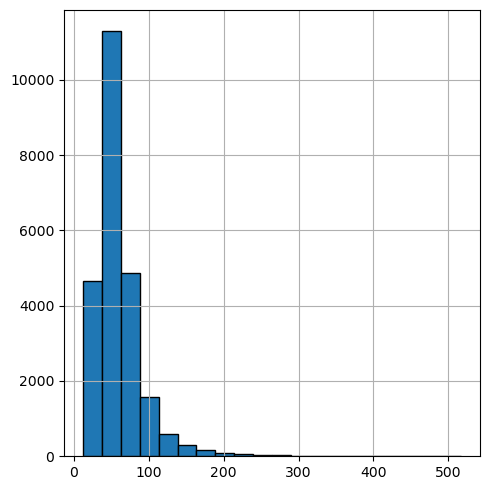

In [38]:
# Построение гистограммы для общей площади 
data['total_area'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

#### Жилая площадь

In [39]:
data['living_area'].describe()

count    23694.000000
mean        34.267682
std         21.090978
min          2.000000
25%         18.800000
50%         30.120000
75%         42.000000
max        347.500000
Name: living_area, dtype: float64

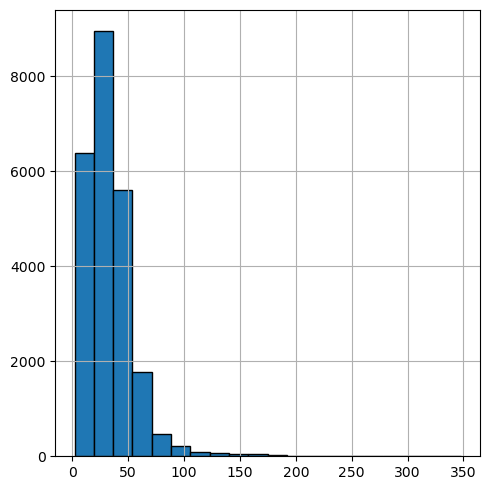

In [40]:
# Построение гистограммы для жилой площади
data['living_area'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

Минимальная жилая площадь в выборке - 2 кв.м. На мой взгляд, это слишком мало.<br>
Посмотрим, сколько объектов с жилой площадью менее 6 кв.м. есть в данных.

In [41]:
data.query('living_area < 6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km
3242,7,4440000.0,41.0,2017-07-02,1,2.60,17,3.0,17,False,False,False,11.0,0,Санкт-Петербург,19272.0,13073.0,0,460.0,0,503.0,216,1,санкт-петербург,108292.68,6,7,2017,последний,13
13915,20,6350000.0,52.0,2018-02-06,2,3.00,6,2.0,2,False,False,False,9.0,0,Санкт-Петербург,32453.0,6521.0,0,460.0,1,1012.0,91,2,санкт-петербург,122115.38,1,2,2018,другой,7
17582,11,2680000.0,22.0,2018-08-11,0,2.58,25,5.0,8,False,True,False,8.0,2,Санкт-Петербург,22735.0,11618.0,1,835.0,1,652.0,70,0,санкт-петербург,121818.18,5,8,2018,другой,12
21758,0,2330000.0,23.0,2018-01-01,0,2.58,24,2.0,22,False,True,False,8.0,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,66,0,мурино,101304.35,0,1,2018,другой,<NA>
21943,15,6100000.0,77.6,2019-02-28,4,2.50,9,5.4,1,False,False,False,9.8,0,Санкт-Петербург,29338.0,11270.0,1,584.0,0,503.0,33,4,санкт-петербург,78608.25,3,2,2019,первый,11
23574,14,64990000.0,139.0,2015-11-24,3,3.00,8,3.0,8,False,False,False,16.0,1,Санкт-Петербург,33255.0,5975.0,1,630.0,3,100.0,280,4,санкт-петербург,467553.96,1,11,2015,последний,6


Получили 6 таких строчкек. Их мы можем спокойно удалить из нашей выборки. 

In [42]:
data = data.query('living_area >= 6')

Максимальная жилая площадь - 347.5 кв.м. Оставим это значение как есть. При максимальной общей площади 517 кв.м. это значение выглядит реалистичным. <br><br>
Теперь вновь посмотрим на столбец с жилой площадью.

In [43]:
data['living_area'].describe()

count    23688.000000
mean        34.275500
std         21.087915
min          6.000000
25%         18.800000
50%         30.165000
75%         42.000000
max        347.500000
Name: living_area, dtype: float64

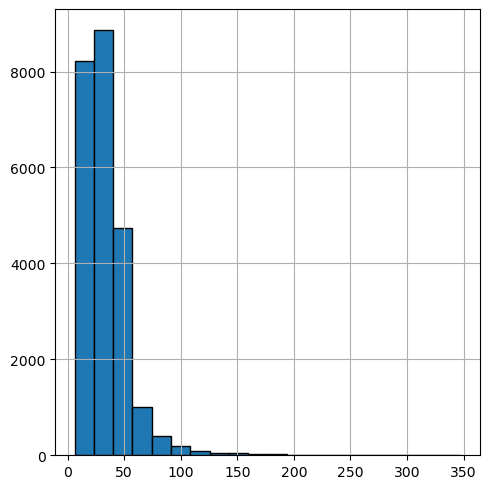

In [44]:
# Построение гистограммы для жилой площади
data['living_area'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

#### Площадь кухни

In [45]:
data['kitchen_area'].describe()

count    23688.000000
mean        10.459614
std          5.568847
min          1.300000
25%          7.360000
50%          9.000000
75%         11.900000
max        107.000000
Name: kitchen_area, dtype: float64

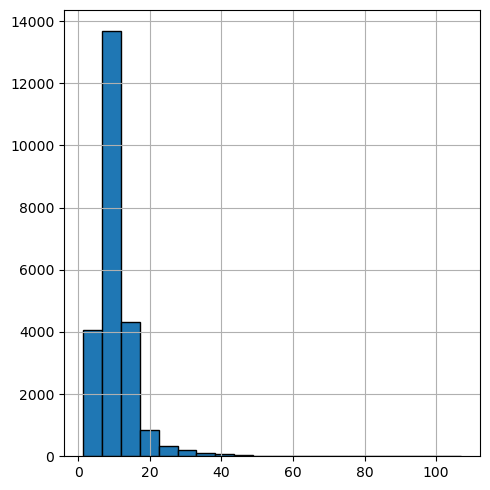

In [46]:
# Построение гистограммы для площади кухни
data['kitchen_area'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

Зависимость площади кухни от общей площади не очевидна. Поэтому будем считать, что эти данные корректны. <br>
Посмотрим, сколько квартир с площадью кухни меньше трех метров квадратных.

In [47]:
data.query('kitchen_area < 3')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km
906,15,2600000.0,27.00,2017-07-10,1,2.75,23,18.0,18,False,False,False,2.00,0,Санкт-Петербург,22131.0,17459.0,0,460.0,1,411.0,10,0,санкт-петербург,96296.30,0,7,2017,другой,17
6262,9,3100000.0,24.00,2018-06-25,2,3.00,5,16.0,5,False,False,False,2.00,0,Санкт-Петербург,31960.0,4914.0,2,426.0,1,936.0,54,0,санкт-петербург,129166.67,0,6,2018,последний,5
7950,3,5967734.0,66.40,2017-02-07,2,2.65,4,44.4,2,False,False,False,2.89,0,Санкт-Петербург,44870.0,20802.0,0,460.0,0,503.0,335,3,санкт-петербург,89875.51,1,2,2017,другой,21
8729,9,2200000.0,18.40,2018-08-20,1,2.52,3,14.0,3,False,False,False,2.40,0,Пушкин,20710.0,30687.0,0,399.5,1,155.0,59,0,пушкин,119565.22,0,8,2018,последний,31
9138,17,2920000.0,23.29,2018-12-12,1,2.58,3,21.0,1,False,False,False,2.00,0,Санкт-Петербург,19506.0,4008.0,0,460.0,2,45.0,107,0,санкт-петербург,125375.70,2,12,2018,первый,4
11033,6,5350000.0,32.00,2016-04-20,1,2.58,14,16.0,10,False,False,False,2.00,0,Санкт-Петербург,19008.0,3953.0,0,460.0,1,69.0,210,0,санкт-петербург,167187.50,2,4,2016,другой,4
16367,2,2720000.0,25.70,2017-10-30,1,2.58,19,22.6,11,False,False,False,2.00,0,Санкт-Петербург,14472.0,13268.0,0,460.0,0,503.0,109,0,санкт-петербург,105836.58,0,10,2017,другой,13
17834,5,2940000.0,34.70,2017-10-09,1,2.58,26,15.5,14,False,False,False,2.30,1,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,318,0,мурино,84726.22,0,10,2017,другой,<NA>
19642,5,1190000.0,14.00,2018-07-29,1,2.58,5,11.0,1,False,False,False,2.00,0,Санкт-Петербург,9898.0,11122.0,0,460.0,0,503.0,4,0,санкт-петербург,85000.00,6,7,2018,первый,11
20217,7,4250000.0,28.50,2019-05-01,1,2.80,14,19.5,10,False,False,False,1.30,0,Санкт-Петербург,37199.0,12721.0,0,460.0,0,503.0,<NA>,0,санкт-петербург,149122.81,2,5,2019,другой,13


Таких значений всего 11. Предположим, что это действительно маленькие кухни и оставим их как есть. <br>
Максимальная площадь кухни - 107 кв.м. Для действительно больших квартир это число выглядит вполне реалистичным.

#### Цена объекта

In [48]:
data['last_price'].describe()

count    2.368800e+04
mean     6.495959e+06
std      1.029240e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Так визуализировать данные неудобно. <br>
Создадим новый столбец, который будет показывать цену в тысячах рублей.

In [49]:
data['price_in_thousands'] = data['last_price'] / 1000

In [50]:
data['price_in_thousands'].describe()

count     23688.000000
mean       6495.958896
std       10292.398449
min          12.190000
25%        3400.000000
50%        4650.000000
75%        6799.000000
max      763000.000000
Name: price_in_thousands, dtype: float64

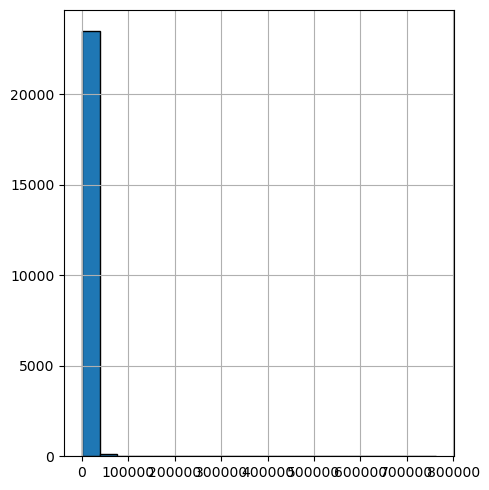

In [51]:
# Построение гистограммы для цены объекта
data['price_in_thousands'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

Тоже некрасиво. <br>
Посмотрим, сколько квартир имют цену более 150 млн. руб.

In [52]:
data.query('price_in_thousands > 150000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km,price_in_thousands
1026,20,155000000.0,310.0,2018-10-12,5,5.30,3,190.0,3,False,False,False,63.0,2,Санкт-Петербург,24899.0,4785.0,0,460.0,1,603.0,<NA>,4,санкт-петербург,500000.00,4,10,2018,последний,5,155000.0
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7,95.0,5,False,False,False,40.0,0,Санкт-Петербург,23011.0,1197.0,3,519.0,3,285.0,233,4,санкт-петербург,1736842.11,2,4,2018,другой,1,330000.0
2536,16,159984000.0,242.4,2015-08-27,4,3.85,9,131.0,7,False,False,False,20.0,0,Санкт-Петербург,21946.0,2242.0,1,679.0,1,227.0,501,4,санкт-петербург,660000.00,3,8,2015,другой,2,159984.0
5893,3,230000000.0,500.0,2017-05-31,6,2.90,7,55.0,7,False,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0,460.0,2,198.0,50,4,санкт-петербург,460000.00,2,5,2017,последний,5,230000.0
8900,13,190870000.0,268.0,2016-03-25,3,2.90,8,132.0,7,False,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0,460.0,2,198.0,901,4,санкт-петербург,712201.49,4,3,2016,другой,5,190870.0
12971,19,763000000.0,400.0,2017-09-30,7,2.90,10,250.0,10,False,False,False,14.0,2,Санкт-Петербург,25108.0,3956.0,1,530.0,3,756.0,33,4,санкт-петербург,1907500.00,5,9,2017,последний,4,763000.0
13749,7,240000000.0,410.0,2017-04-01,6,3.40,7,218.0,7,False,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0,460.0,2,198.0,199,4,санкт-петербург,585365.85,5,4,2017,последний,5,240000.0
14706,15,401300000.0,401.0,2016-02-20,5,2.90,9,204.0,9,False,False,False,24.0,3,Санкт-Петербург,21912.0,2389.0,1,545.0,1,478.0,393,4,санкт-петербург,1000748.13,5,2,2016,последний,2,401300.0
16461,17,245000000.0,285.7,2017-04-10,6,3.35,7,182.8,4,False,False,False,29.8,0,Санкт-Петербург,33143.0,6235.0,3,400.0,3,140.0,249,4,санкт-петербург,857542.88,0,4,2017,другой,6,245000.0
16495,12,159000000.0,260.0,2017-04-04,4,2.90,5,180.0,4,False,False,False,30.0,2,Санкт-Петербург,21740.0,436.0,2,138.0,3,620.0,178,4,санкт-петербург,611538.46,1,4,2017,другой,0,159000.0


Значения кажутся аномально большими, поэтому исключим их из анализа. Их очень мало, поэтому на общую выборку это не повлияет.

In [53]:
data = data.query('price_in_thousands <= 150000')

Минимальное значение тоже сильно отличается от остальных: всего одна квартира стоит 12000 руб.

In [54]:
data.query('price_in_thousands <= 400')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km,price_in_thousands
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,503.0,8,4,санкт-петербург,111.83,2,3,2019,последний,9,12.19


In [55]:
data.query('price_in_thousands <= 500')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km,price_in_thousands
2097,9,500000.0,30.7,2019-04-30,1,2.58,2,15.1,2,False,False,False,7.4,0,деревня Чудской Бор,NaN,NaN,0,NaN,0,NaN,<NA>,0,чудской бор,16286.64,1,4,2019,последний,<NA>,500.00
4405,9,500000.0,52.0,2018-08-02,2,2.70,2,31.0,1,False,False,False,8.0,0,Сланцы,NaN,NaN,0,NaN,0,NaN,110,2,сланцы,9615.38,3,8,2018,первый,<NA>,500.00
5698,7,450000.0,42.0,2017-07-31,2,2.60,1,23.0,1,False,False,False,5.8,0,городской посёлок Будогощь,NaN,NaN,0,NaN,0,NaN,233,1,будогощь,10714.29,0,7,2017,первый,<NA>,450.00
6859,6,490000.0,40.0,2017-12-11,1,2.60,5,20.2,3,False,False,False,9.0,0,деревня Старополье,NaN,NaN,0,NaN,0,NaN,43,1,старополье,12250.00,0,12,2017,другой,<NA>,490.00
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,503.0,8,4,санкт-петербург,111.83,2,3,2019,последний,9,12.19
9581,7,450000.0,43.4,2018-08-31,2,2.60,5,30.3,3,False,False,False,5.5,0,деревня Старополье,NaN,NaN,0,NaN,0,NaN,96,1,старополье,10368.66,4,8,2018,другой,<NA>,450.00
10782,3,490000.0,29.1,2016-05-05,1,2.50,5,17.0,5,False,False,False,5.5,0,Сланцы,NaN,NaN,0,NaN,0,NaN,719,0,сланцы,16838.49,3,5,2016,последний,<NA>,490.00
14295,4,500000.0,34.0,2016-02-09,1,2.58,5,17.0,4,False,False,False,8.0,1,поселок городского типа Никольский,NaN,NaN,0,NaN,0,NaN,724,0,никольский,14705.88,1,2,2016,другой,<NA>,500.00
14904,3,500000.0,38.0,2018-02-08,1,2.60,3,20.2,3,False,False,False,9.0,0,деревня Бор,NaN,NaN,0,NaN,0,NaN,44,1,бор,13157.89,3,2,2018,последний,<NA>,500.00
14911,5,430000.0,54.0,2018-06-26,2,2.60,3,30.5,3,False,False,False,8.4,0,посёлок станции Свирь,NaN,NaN,0,NaN,0,NaN,44,2,станции свирь,7962.96,1,6,2018,последний,<NA>,430.00


Так что эту одну квартиру тоже уберем как аномальное значение.

In [56]:
data = data.query('price_in_thousands >= 400')

Теперь вновь посмотрим на столбец цены объекта в тыс.руб.

In [57]:
data['price_in_thousands'].describe()

count     23674.000000
mean       6351.815061
std        7347.637153
min         430.000000
25%        3400.000000
50%        4650.000000
75%        6787.500000
max      150000.000000
Name: price_in_thousands, dtype: float64

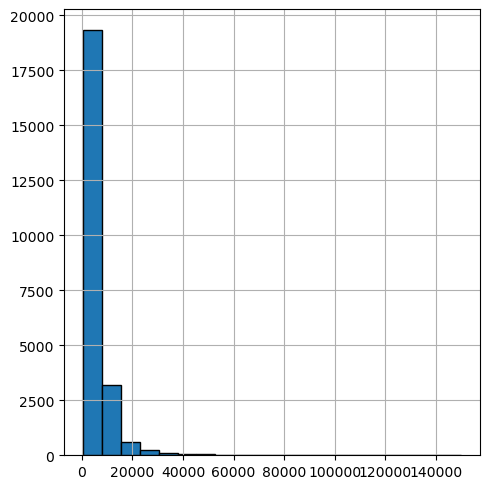

In [58]:
# Построение гистограммы для цены объекта
data['price_in_thousands'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

#### Количество комнат

In [59]:
data['rooms'].describe()

count    23674.000000
mean         2.067585
std          1.069262
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

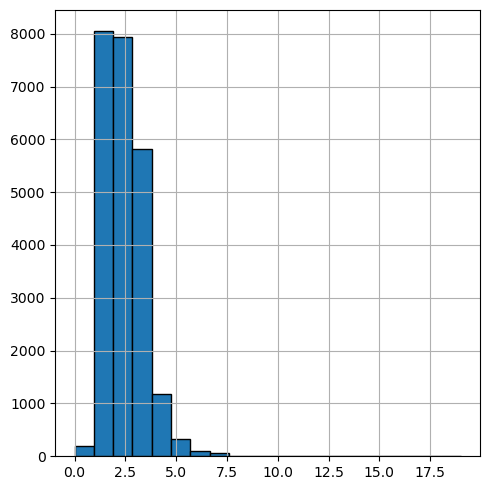

In [60]:
# Построение гистограммы для количества комнат
data['rooms'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

Странно, что есть квартиры без комнат.<br>
Посмотрим на них.

In [61]:
data.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km,price_in_thousands
144,1,2450000.0,27.00,2017-03-30,0,2.58,24,15.50,2,False,True,False,8.0,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,181,0,мурино,90740.74,3,3,2017,другой,<NA>,2450.0
349,4,2320000.0,25.00,2017-09-27,0,2.58,14,17.00,1,False,False,True,8.0,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,45,0,кудрово,92800.00,2,9,2017,первый,<NA>,2320.0
440,8,2480000.0,27.11,2018-03-12,0,2.58,17,24.75,4,False,True,False,8.0,2,Санкт-Петербург,38171.0,15015.0,0,460.0,2,982.0,64,0,санкт-петербург,91479.16,0,3,2018,другой,15,2480.0
508,0,3375000.0,34.40,2017-03-28,0,2.58,26,24.30,19,False,False,True,8.0,1,посёлок Парголово,53115.0,19292.0,0,733.0,1,593.0,430,0,парголово,98110.47,1,3,2017,другой,19,3375.0
608,2,1850000.0,25.00,2019-02-20,0,2.58,10,17.00,7,False,True,False,8.0,0,посёлок Шушары,17427.0,24212.0,0,NaN,0,584.5,29,0,шушары,74000.00,2,2,2019,другой,24,1850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01,0,2.58,25,18.00,16,False,True,False,8.0,0,Санкт-Петербург,11405.0,13222.0,0,460.0,1,623.0,14,0,санкт-петербург,123076.92,4,9,2017,другой,13,3200.0
23442,0,2500000.0,27.70,2017-09-28,0,2.58,24,18.00,4,False,False,True,8.0,2,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,4,0,мурино,90252.71,3,9,2017,другой,<NA>,2500.0
23554,15,3350000.0,26.00,2018-09-07,0,2.58,19,17.00,8,False,True,False,8.0,0,Санкт-Петербург,18090.0,17092.0,0,460.0,2,112.0,31,0,санкт-петербург,128846.15,4,9,2018,другой,17,3350.0
23592,10,1450000.0,29.00,2017-11-11,0,2.58,9,18.00,8,False,False,True,8.0,2,Никольское,NaN,NaN,0,NaN,0,NaN,82,0,никольское,50000.00,5,11,2017,другой,<NA>,1450.0


Скорее всего, это квартиры-студии, поскольку общая площадь около 25 кв.м. <br>
Мы можем присвоить этим квартирам в столбец <i> rooms</i> значение 1. Их не так много, но удалять их смысла нет.

In [62]:
# Присвоение квартирам-студиям значение 1 в столбец rooms
data.loc[data['rooms'] == 0, 'rooms'] = 1

Теперь посмотрим, у скольких квартир количество комнат больше 8

In [63]:
data.query('rooms > 8')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km,price_in_thousands
648,3,17500000.0,183.7,2018-07-01,11,3.40,7,138.8,7,False,False,False,13.3,0,Санкт-Петербург,23606.0,3148.0,0,460.0,0,503.0,<NA>,4,санкт-петербург,95264.02,6,7,2018,последний,3,17500.0
866,5,25000000.0,363.0,2017-12-23,14,3.16,5,222.0,4,False,False,False,16.6,0,Санкт-Петербург,38076.0,7950.0,0,460.0,2,435.0,418,4,санкт-петербург,68870.52,5,12,2017,другой,8,25000.0
4149,6,23000000.0,272.6,2018-01-11,10,3.14,7,145.9,7,False,False,False,18.8,1,Санкт-Петербург,10726.0,12169.0,1,191.0,1,531.0,<NA>,4,санкт-петербург,84372.71,3,1,2018,последний,12,23000.0
8822,14,49968900.0,398.0,2017-07-12,9,3.00,2,160.1,1,False,False,False,41.0,0,Санкт-Петербург,17720.0,16722.0,3,471.0,2,440.0,471,4,санкт-петербург,125550.00,2,7,2017,первый,17,49968.9
8860,12,17000000.0,235.0,2018-07-14,9,3.00,6,55.0,3,False,False,False,14.0,0,Санкт-Петербург,24466.0,5034.0,1,346.0,0,503.0,90,4,санкт-петербург,72340.43,5,7,2018,другой,5,17000.0
9550,10,23500000.0,313.0,2017-02-13,9,3.20,6,179.2,5,False,False,False,13.2,0,Санкт-Петербург,38435.0,10138.0,1,146.0,0,503.0,<NA>,4,санкт-петербург,75079.87,0,2,2017,другой,10,23500.0
9688,8,33000000.0,194.1,2017-02-07,11,3.43,5,129.0,2,False,False,False,11.9,0,Санкт-Петербург,21469.0,1015.0,1,686.0,2,66.0,813,4,санкт-петербург,170015.46,1,2,2017,другой,1,33000.0
13019,0,22250000.0,249.9,2019-04-23,9,3.20,5,157.0,5,False,False,False,12.4,0,Санкт-Петербург,10328.0,9987.0,2,352.0,0,503.0,<NA>,4,санкт-петербург,89035.61,1,4,2019,последний,10,22250.0
13397,14,19500000.0,309.7,2016-02-03,9,2.90,5,199.0,5,False,False,False,14.3,0,Санкт-Петербург,10328.0,9987.0,2,352.0,0,503.0,468,4,санкт-петербург,62964.16,2,2,2016,последний,10,19500.0
14498,6,32250000.0,374.6,2018-06-09,19,2.90,5,264.5,2,False,False,False,27.6,0,Санкт-Петербург,19497.0,3574.0,0,460.0,2,548.0,114,4,санкт-петербург,86091.83,5,6,2018,другой,4,32250.0


Можем убрать из анализа квартиры, у которых более 10 комнат. Этих значений мало, и они выглядят аномально. <br>
Например, при общей площади 270 кв. м. имеем 16 комнат. Получается примерно по 16.7 кв.м. на каждую комнату, и это если делить общую площать, а не жилую, которая ещё меньше. Много относительно небольших комнат, выглядит аномально.

In [64]:
data = data.query('rooms <= 10')

Теперь ещё раз посмотрим на количество комнат.

In [65]:
data['rooms'].describe()

count    23668.000000
mean         2.072756
std          1.038587
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: rooms, dtype: float64

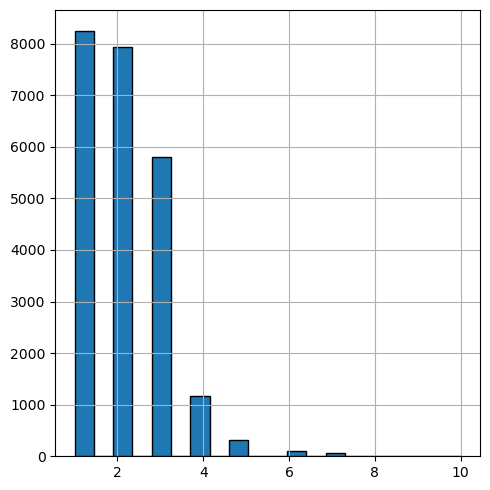

In [66]:
# Построение гистограммы для количества комнат
data['rooms'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

#### Высота потолков

In [67]:
data['ceiling_height'].describe()

count    23668.000000
mean         2.726329
std          0.990945
min          1.000000
25%          2.580000
50%          2.600000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

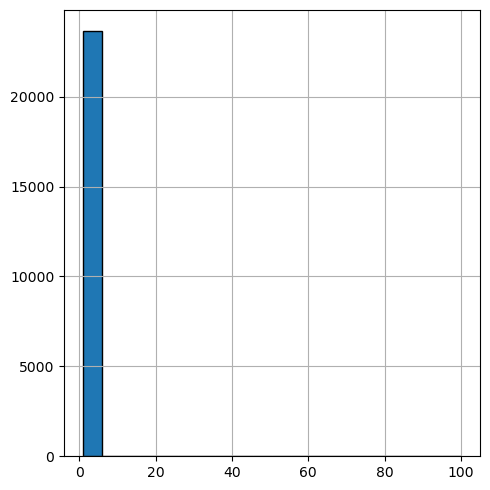

In [68]:
# Построение гистограммы для высоты потолков
data['ceiling_height'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

Тут есть аномальные значения. Если высота потолков 25 метров, то это скорее всего 2.5 метра и так далее. <br> 
Нужно учесть, что  значения от 5 до 25 метров поделить на 10 не выйдет, получится слишком мало, а значения более 50 (при делении получается более 5 метров) слишком большие. Все эти варианты аномальны. <br>
Будем считать, что максимальная высота потолков - 5 метров, а минимальная - 2.5 метров.

Таким образом, значения от 25 от 50 метров мы поделим на 10, тут, скорее всего, пользователи ошиблись при заполнении.<br>
Значения до 2.5 метров, значения от 5 до 25 не включительно и значения от 50 метров мы не будет учитывать. 

In [69]:
# Корректировка значений высоты потолков, которые, вероятно, были ошибочно введены
data.loc[data['ceiling_height'].between(25, 50), 'ceiling_height'] /= 10

# Удаление аномальных значений: высота потолков меньше 2.5 м, от 5 до 25 м (не включая) и более 50 м
# Поскольку мы поделили значения от 25 до 50 на 10, то все нужные значения находятся от 2.5 до 5
data = data[(data['ceiling_height'] >= 2.5) & (data['ceiling_height'] < 5)]

Ещё раз посмотрим на высоту потолков.

In [70]:
data['ceiling_height'].describe()

count    23578.000000
mean         2.699082
std          0.224554
min          2.500000
25%          2.580000
50%          2.600000
75%          2.750000
max          4.900000
Name: ceiling_height, dtype: float64

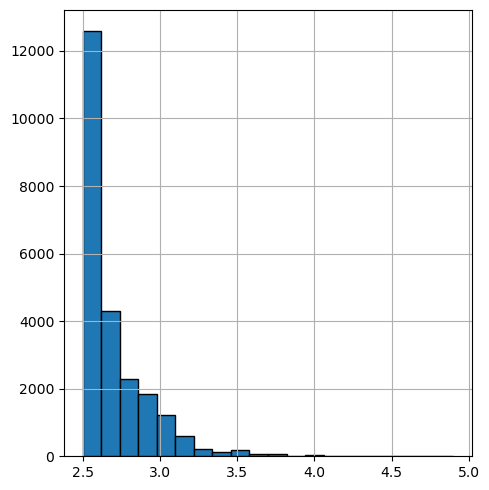

In [71]:
# Построение гистограммы для высоты потолков
data['ceiling_height'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

#### Тип этажа квартиры

In [72]:
data['floor_type'].describe()

count      23578
unique         3
top       другой
freq       17373
Name: floor_type, dtype: object

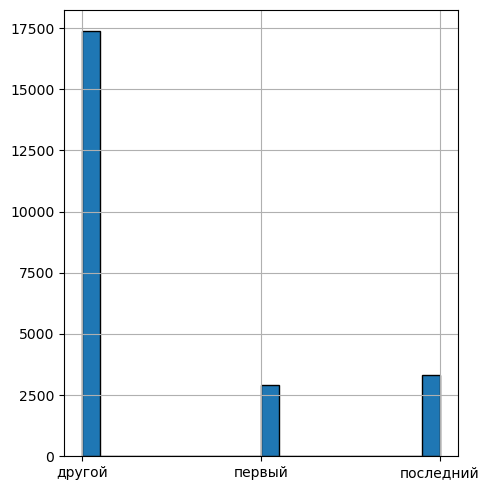

In [73]:
# Построение гистограммы для типа этажа квартиры
data['floor_type'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

Такое распределение типов этажей выглядит вполне реалистично. <br>
В этом столбце ничего менять не будем.

#### Общее количество этажей в доме

In [74]:
data['floors_total'].describe()

count    23578.000000
mean        10.683137
std          6.590198
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

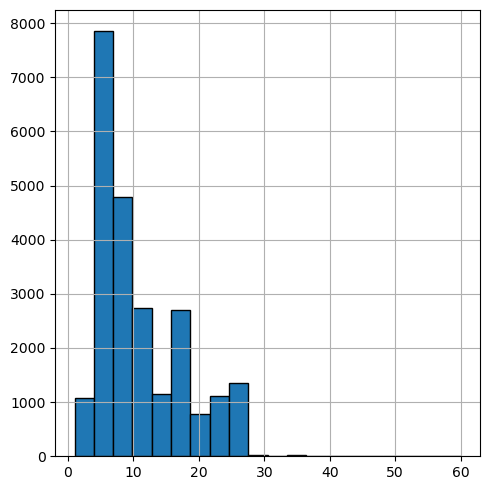

In [75]:
# Построение гистограммы для общего количества этажей в доме
data['floors_total'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

Судя по статье https://dzen.ru/a/Y9QUja9rKGbOYWX2, возьмем максимальное количество этажей в доме - 35.<br>
Минимальное получилось 1, это корректно. <br>
Посмотрим, сколько квартир имеют в доме более 35 этажей.

In [76]:
data.query('floors_total > 35')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_category,unique_locality_name,price_per_sqm,weekday_published,month_published,year_published,floor_type,cityCenters_nearest_km,price_in_thousands
397,15,5990000.0,54.0,2018-03-22,2,2.60,36,21.4,28,False,False,False,18.7,1,Санкт-Петербург,18732.0,20444.0,0,460.0,3,80.0,11,2,санкт-петербург,110925.93,3,3,2018,другой,20,5990.0
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60,27.4,4,False,False,False,7.4,0,Кронштадт,67763.0,49488.0,2,342.0,3,614.0,166,1,кронштадт,83516.48,3,6,2018,другой,49,3800.0
5807,17,8150000.0,80.0,2019-01-09,2,2.70,36,41.0,13,False,False,False,12.0,5,Санкт-Петербург,18732.0,20444.0,0,460.0,3,80.0,38,4,санкт-петербург,101875.00,2,1,2019,другой,20,8150.0
11079,16,9200000.0,75.0,2019-02-22,2,2.70,36,40.0,29,False,False,False,12.0,2,Санкт-Петербург,18732.0,20444.0,0,460.0,3,80.0,<NA>,3,санкт-петербург,122666.67,4,2,2019,другой,20,9200.0
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52,10.5,18,False,False,False,14.0,0,Санкт-Петербург,20728.0,12978.0,1,793.0,0,503.0,45,1,санкт-петербург,99450.00,0,9,2018,другой,13,3978.0


Эти 5 квартир можем считать аномальными и не учитывать при анализе.

In [77]:
data = data.query('floors_total <= 35')

Ещё раз посмотрим на общее количество этажей в домах.

In [78]:
data['floors_total'].describe()

count    23573.000000
mean        10.676070
std          6.571354
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         35.000000
Name: floors_total, dtype: float64

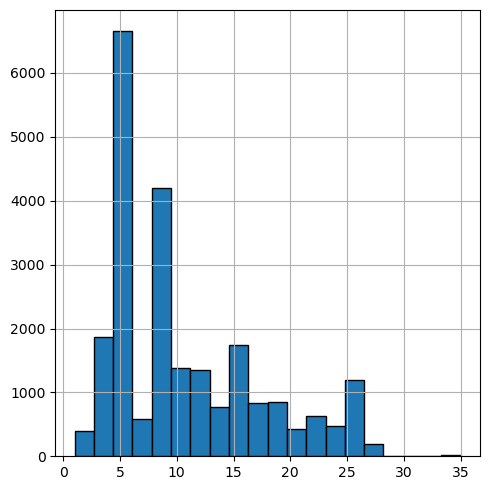

In [79]:
# Построение гистограммы для общего количества этажей в доме
data['floors_total'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

#### Расстояние до центра города в метрах

In [80]:
data['cityCenters_nearest'].describe()

count    18221.000000
mean     14241.882663
std       8620.183576
min        181.000000
25%       9289.000000
50%      13107.000000
75%      16333.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

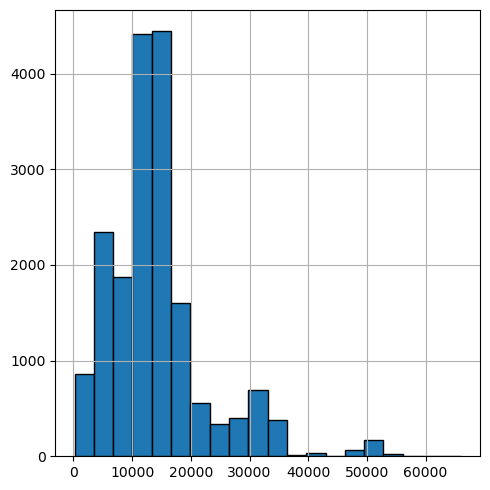

In [81]:
# Построение гистограммы для расстояния до центра города в метрах
data['cityCenters_nearest'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

Минимальное расстояние - 181 метр, практически в центре города.<br>
Максимальное расстроение - 66 километров, например, от какой-то деревни. <br>
В целом, значения выглядят реалистично.

#### Расстояние до ближайшего парка

In [82]:
data['parks_nearest'].describe()

count    17611.000000
mean       475.915905
std        235.734576
min          1.000000
25%        428.500000
50%        460.000000
75%        460.000000
max       3190.000000
Name: parks_nearest, dtype: float64

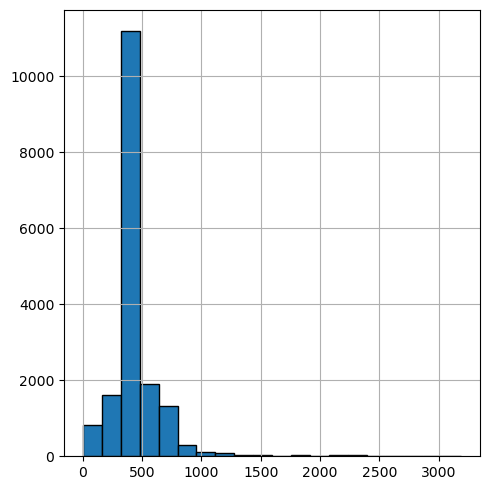

In [83]:
# Построение гистограммы для расстояния до ближайшего парка
data['parks_nearest'].hist(figsize=(5, 5), bins=20, edgecolor='black')

# Настройка вывода графиков
plt.tight_layout()
plt.show()

Здесь минимальное расстрояние получилось 1 метр. То есть дом находится у самого парка. <br>
Максимальное расстояние 3190 метров. <br>
Значения выглядят реалистично. Оставим их как есть.

Итого, в ходе выполнения этого блока мы подробно изучили 10 параметров, которые могут влять на рыночную стоимость объектов недвижимости. <br>
Так же мы отфильтровали аномальные значения в этих столбцах. Изначально у нас было 23699 строк, а после фильтрации аномальных значений осталось 23573 строк. То есть мы убрали из анализа 126 строк, это около 0.5% от исходных данных. Результат неплохой, такое небольшое количество удаленных данных не должно повлиять на дальнейший анализ.

### Скорость продажи квартир

Необходимо изучить,  как быстро продавались квартиры. <br>
Будем использовать столбец <i> days_exposition</i>. Этот параметр показывает, сколько дней было размещено каждое объявление.<br>
Ранее мы не стали заполнять пропуски в этом столбце, считая, что для этих данных объявления ещё не были сняты с публикации на момент сбора данных. Поэтому для этой задачи не будем брать данные с пропусками в расчет.<br>
Построим гистограмму, посчитаем среднее и медиану.

In [84]:
data['days_exposition'].describe()

count       20410.0
mean     180.854581
std      219.695798
min             1.0
25%            45.0
50%            95.0
75%           232.0
max          1580.0
Name: days_exposition, dtype: Float64

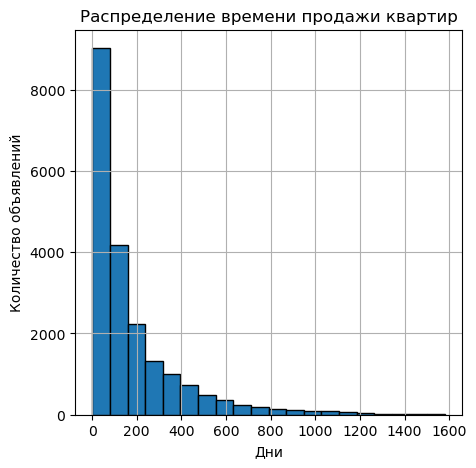

In [85]:
# Построение гистограммы
plt.figure(figsize=(5, 5))
plt.hist(data['days_exposition'].dropna(), bins=20, edgecolor='black')
plt.title('Распределение времени продажи квартир')
plt.xlabel('Дни')
plt.ylabel('Количество объявлений')
plt.grid(True)
plt.show()

In [86]:
# Расчет среднего значения и медианы
mean_days = data['days_exposition'].mean()
median_days = data['days_exposition'].median()

print(f"Среднее количество дней: {mean_days:.2f}")
print(f"Медианное количество дней: {median_days}")

Среднее количество дней: 180.85
Медианное количество дней: 95.0


Из гистограммы видно, что распределение скошено вправо. Это означает, что есть объявления, которые висят очень долго. Это влияет на среднее значение, делая его выше медианы. <br>
Среднее время продажи квартир составляет около 181 дня, в то время как медианное - 95 дней. Это различие между средним и медианой указывает на наличие длинного "хвоста" в распределении, где некоторые квартиры продаются необычно долго.

Исходя из наших данных:<br>
- <i>Быстрые продажи </i> определим как те, что произошли за меньшее время, чем медианное, например, менее 45 дней;
- <i>Обычные продажи </i> будут те, которые находятся в районе медианного значения, то есть от 45 до 150 дней;
- <i>Необычно долгие продажи </i> определим как те, что заняли более 200 дней. Особенно продажи, которые заняли значительно больше среднего времени, например более 360 дней, следует рассматривать как особо долгие.

### Факторы, которые больше всего влияют на общую (полную) стоимость объекта

Необходимо изучить, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

Построим графики, которые покажут зависимость цены от указанных выше параметров. А так же посчитаем коэффициент корреляции Пирсона.

#### Влияние общей площади на полную стоимость объекта

<Axes: xlabel='total_area', ylabel='price_in_thousands'>

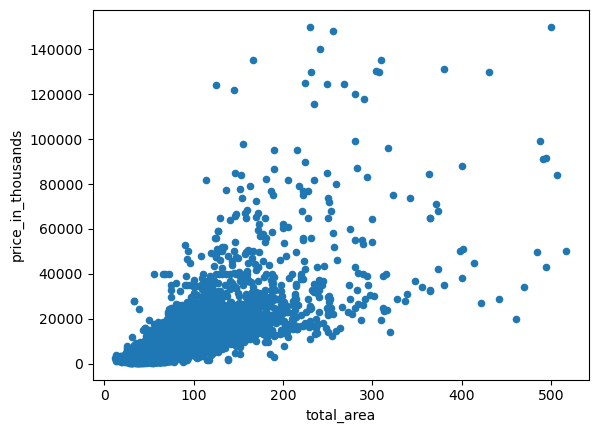

In [87]:
# Построение графика зависимости цены в тыс.руб. от общей площади
data.plot(x='total_area', y='price_in_thousands', kind='scatter') 

In [88]:
# Нахождения коэффициента корреляции Пирсона
data['price_in_thousands'].corr(data['total_area'])

0.7461304734026352

По графику и коэффициенту корреляции Пирсона можно сказать, что зависимость цены от общей площади квартиры выглядит линейной.<br> 
Чем больше общая площадь, тем выше цена.

#### Влияние жилой площади на полную стоимость объекта

<Axes: xlabel='living_area', ylabel='price_in_thousands'>

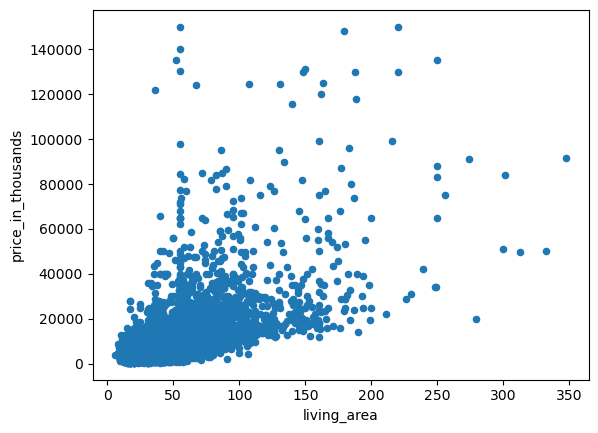

In [89]:
# Построение графика зависимости цены в тыс.руб. от жилой площади
data.plot(x='living_area', y='price_in_thousands', kind='scatter') 

In [90]:
# Нахождения коэффициента корреляции Пирсона
data['price_in_thousands'].corr(data['living_area'])

0.6414819593757363

Схожий с общей площадью тренд, где большая жилая площадь ведет к увеличению цены.

#### Влияние площади кухни на полную стоимость объекта

<Axes: xlabel='kitchen_area', ylabel='price_in_thousands'>

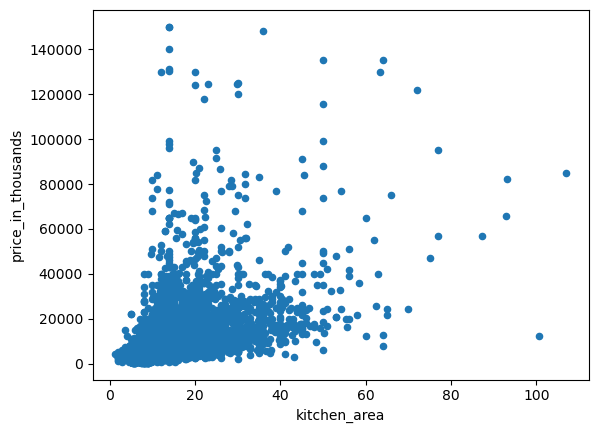

In [91]:
# Построение графика зависимости цены в тыс.руб. от площади кухни
data.plot(x='kitchen_area', y='price_in_thousands', kind='scatter') 

In [92]:
# Нахождения коэффициента корреляции Пирсона
data['price_in_thousands'].corr(data['kitchen_area'])

0.5475926918335632

Здесь наблюдается меньшая, но заметная зависимость, показывающая, что более просторные кухни также могут влиять на повышение стоимости.

#### Влияние количества комнат на полную стоимость объекта

<Axes: xlabel='rooms', ylabel='price_in_thousands'>

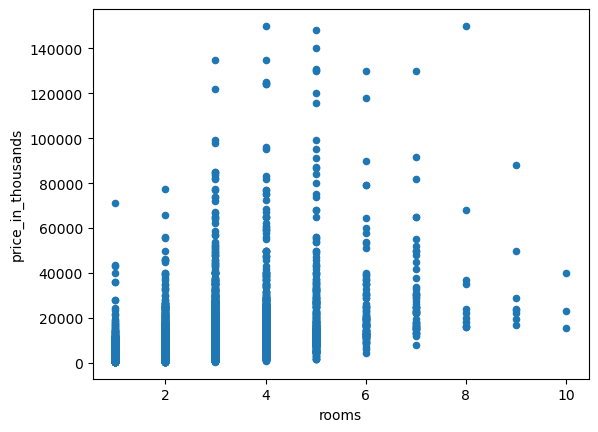

In [93]:
# Построение графика зависимости цены в тыс.руб. от количества комнат
data.plot(x='rooms', y='price_in_thousands', kind='scatter') 

Не самый удобный график для анализа. Рассмотрим еще один способ.

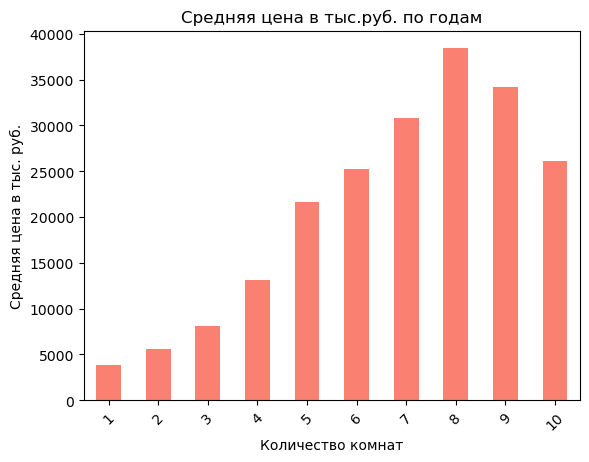

In [94]:
# Агрегируем данные, вычисляя среднюю цену по количеству комнат
average_prices_year = data.groupby('rooms')['price_in_thousands'].mean()

# Построение столбчатой диаграммы
average_prices_year.plot(kind='bar', color='salmon')
plt.title('Средняя цена в тыс.руб. по годам')
plt.xlabel('Количество комнат')
plt.ylabel('Средняя цена в тыс. руб.')
plt.xticks(rotation=45)  # Поворот для лучшей читаемости
plt.show()

In [95]:
# Нахождения коэффициента корреляции Пирсона
data['price_in_thousands'].corr(data['rooms'])

0.44755858606443166

Цена увеличивается с ростом количества комнат, хотя после определенного количества комнат стоимость может стабилизироваться или расти менее интенсивно. Это так же связано с тем, что квартир с большим количеством комнат (более 8) намного меньше, чем остальных квартир.

#### Влияние этажа, на котором расположена квартира, на полную стоимость объекта

Для следующих двух параметров (тип этажа и дата) не будем считать коэффициент корреляции Пирсона, поскольку цена от них не зависит линейно, это будет не эффективно. <br> 
Так же постоим графики других типов, чтобы визуализация лучше помогла нам с анализом.

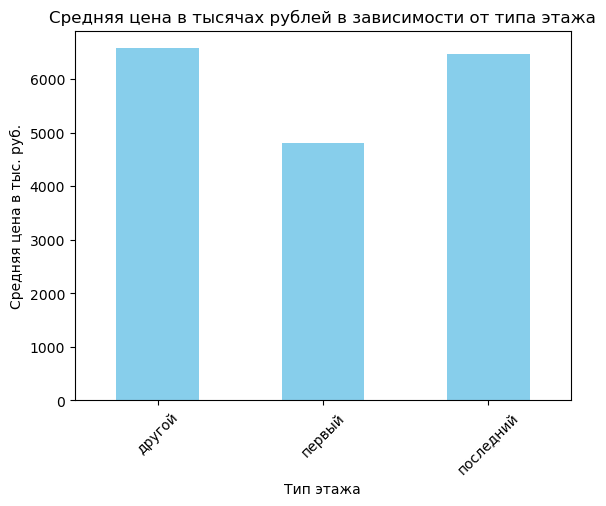

In [96]:
# Сначала агрегируем данные, вычисляя среднюю цену для каждого типа этажа
average_prices = data.groupby('floor_type')['price_in_thousands'].mean()

# Теперь строим столбчатую диаграмму
average_prices.plot(kind='bar', color='skyblue')
plt.title('Средняя цена в тысячах рублей в зависимости от типа этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Средняя цена в тыс. руб.')
plt.xticks(rotation=45)  # Поворот названий на оси X для лучшей читаемости
plt.show()

По графику видно, что квартиры на первом этаже обычно стоят дешевле, чем на других этажах.<br>
А квартиры на последнем этаже имеют схожую цену с квартирами на "других" этажах, что может указывать на нейтральное восприятие последнего этажа покупателями.

#### Влияние даты размещения на полную стоимость объекта

Проведем анализ аналогично прошлому параметру.

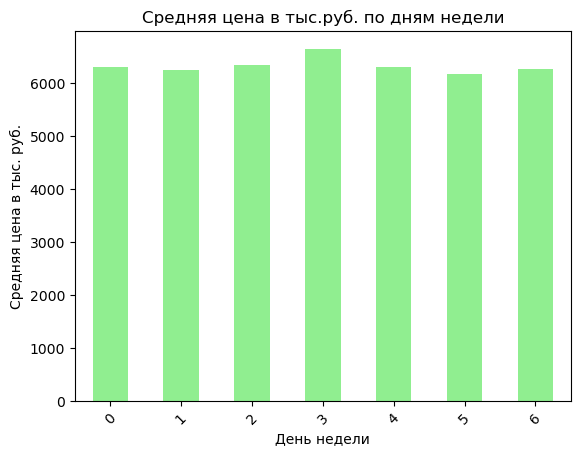

In [97]:
# Агрегация по дню недели
average_prices_weekday = data.groupby('weekday_published')['price_in_thousands'].mean()

# Построение столбчатой диаграммы
average_prices_weekday.plot(kind='bar', color='lightgreen')
plt.title('Средняя цена в тыс.руб. по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средняя цена в тыс. руб.')
plt.xticks(rotation=45)  # Поворот для лучшей читаемости
plt.show()

По результатам можно сделать вывод, что от дня недели цена не зависит.<br>
Хотя иногда цены на недвижимость могут быть немного выше в начале рабочей недели (с понедельника по четверг).<br>
Это может быть связано с тем, что агенты и продавцы "активизируют" свою деятельность после выходных.

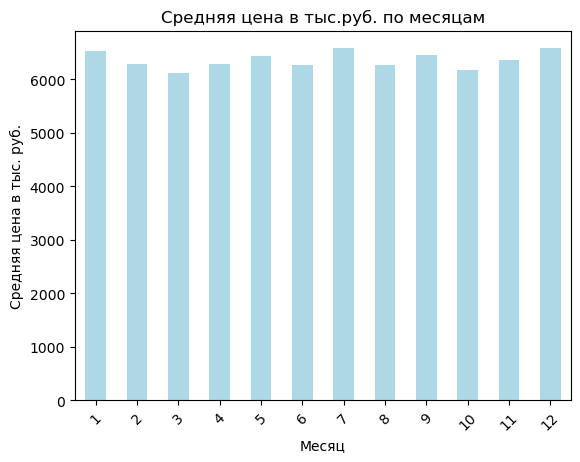

In [98]:
# Агрегация по месяцу
average_prices_month = data.groupby('month_published')['price_in_thousands'].mean()

# Построение столбчатой диаграммы
average_prices_month.plot(kind='bar', color='lightblue')
plt.title('Средняя цена в тыс.руб. по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя цена в тыс. руб.')
plt.xticks(rotation=45)  # Поворот для лучшей читаемости
plt.show()

Видно, что цены на недвижимость могут немного колебаться в зависимости от сезона.<br>
Например, повышение цен видно в январе, мае, июле и сентябре. В целом, явной зависимости здесь не наблюдается.

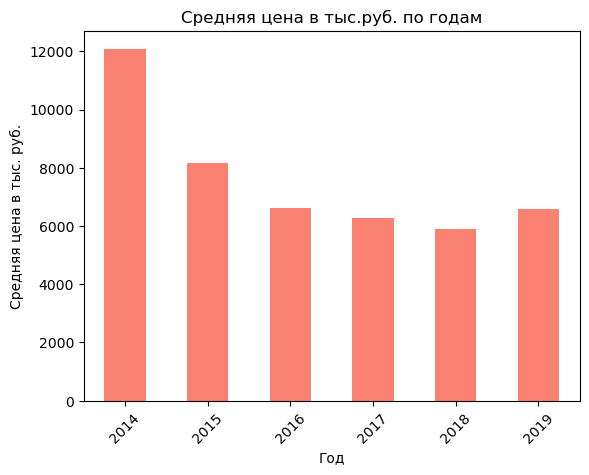

In [99]:
# Агрегация по году
average_prices_year = data.groupby('year_published')['price_in_thousands'].mean()

# Построение столбчатой диаграммы
average_prices_year.plot(kind='bar', color='salmon')
plt.title('Средняя цена в тыс.руб. по годам')
plt.xlabel('Год')
plt.ylabel('Средняя цена в тыс. руб.')
plt.xticks(rotation=45)  # Поворот для лучшей читаемости
plt.show()

По графику можно сказать, что наблюдалась тенденция к снижению средней стоимости недвижимости с годами, вплоть до 2018 года. Затем средняя стоимость немного увеличилась.

В этом блоке мы исследовали факторы, которые больше всего влияют на общую (полную) стоимость объекта.<br>
Больше всего на стоимость объекта влияет общая площадь, коэффициент корреляции Пирсона составил 0.75, это говорит о практически линейной зависимости. Чем больше общая площадь, тем выше стоимость объекта. Аналогичная, но немного менее заметная, ситуация с жилой площадью и площадью кухни.<br>
Так же стоимость объекта растет с увеличением количества комнат до определенного момента. Если количество комнат уже достаточно больше, например, 7, то стоимость объекта может стабилизироваться. Это так же может быть связано с небольшим количесвом данных по квартирам с большим количеством комнат. <br>
Квартиры на первом этаже обычно стоят дешевле, чем на других этажах. А квартиры на последнем этаже имеют схожую стоимость с квартирами на "других" этажах, что, скорее всего, указывает на нейтральное восприятие последнего этажа покупателями.<br>
Дата размещения объявления практически не влияет на стоимость объекта, однако наблюдалась тенденция к снижению средней стоимости недвижимости с годами, вплоть до 2018 года.

### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Необходимо посчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

Построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов.<br>
А так же выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

Ранее мы нашли уникальные названия населенных пунктов, поэтому будет использовать именно их.

In [100]:
# Группировка данных по населенным пунктам и подсчет количества объявлений и средней цены за квадратный метр
locality_stats = data.groupby('unique_locality_name').agg(
    count=('price_per_sqm', 'count'), 
    mean_price_per_sqm=('price_per_sqm', 'mean')
).sort_values(by='count', ascending=False).head(10)

# Форматирование средней цены за квадратный метр до двух знаков после запятой
locality_stats['mean_price_per_sqm'] = locality_stats['mean_price_per_sqm'].round(2)

# Сортировка по средней цене для выделения населенных пунктов с самой высокой и низкой стоимостью
sorted_locality_stats = locality_stats.sort_values(by='mean_price_per_sqm', ascending=False)
sorted_locality_stats

,count,mean_price_per_sqm
unique_locality_name,,
санкт-петербург,15640,114076.05
пушкин,366,103147.83
кудрово,471,95326.18
парголово,326,90205.42
мурино,589,86061.68
шушары,440,78677.36
колпино,337,75443.97
гатчина,307,68746.15
всеволожск,397,68719.32


Итак, мы посчитали среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.<br>
По таблице видно, что самая высокая стоимостью квадратного метра у данной группы в Санкт-Петербурге, 114076 рублей за квардратный метр. А самая низкая - в Выборге, 58238 рублей за квардратный метр.

### Средняя стоимость квартир в Санкт-Петербурге на разном удалении от центра

Необходимо выделить квартиры в Санкт-Петербурге и вычислить их среднюю стоимость на разном удалении от центра.

Учтём каждый километр расстояния: узнаем среднюю цену квартир в одном километре от центра, в двух и так далее.

In [101]:
# Фильтрация квартир в Санкт-Петербурге
spb_data = data[data['unique_locality_name'] == 'санкт-петербург']

# Группировка данных по километрам от центра и расчет средней цены для каждого километра
price_per_km = spb_data.groupby('cityCenters_nearest_km')['price_in_thousands'].mean()

price_per_km.reset_index()

,cityCenters_nearest_km,price_in_thousands
0,0,26543.312615
1,1,17386.374326
2,2,16040.508404
3,3,11108.319057
4,4,11939.198702
5,5,13030.978459
6,6,14690.624083
7,7,14563.172868
8,8,9245.740585
9,9,6983.772699


Опишем, как стоимость объектов зависит от расстояния до центра города — построим график изменения средней цены для каждого километра от центра Петербурга.

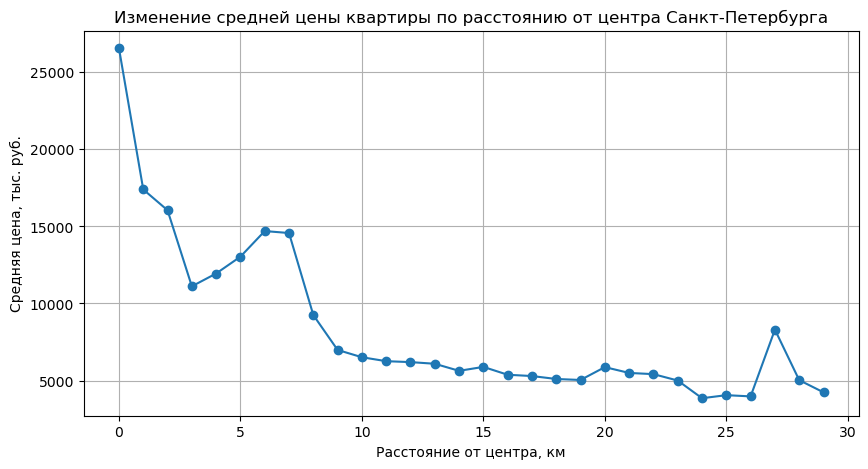

In [102]:
# Построение графика изменения средней цены по километрам от центра
plt.figure(figsize=(10, 5))
price_per_km.plot(kind='line', marker='o')
plt.title('Изменение средней цены квартиры по расстоянию от центра Санкт-Петербурга')
plt.xlabel('Расстояние от центра, км')
plt.ylabel('Средняя цена, тыс. руб.')
plt.grid(True)
plt.show()

Таким образом, мы рассмотрели среднюю стоимость квартир в Санкт-Петербурге на разном удалении от центра. <br>
Из таблицы и графика можно сделать следующие наблюдения:
- Средняя цена наиболее высока в самом центре города и резко снижается при удалении на расстояние в 1 км от центра;
- С увеличением расстрояния цена продолжает снижаться приблизительно до 8 км от центра;
- После 8 км идет более мягкое снижение цены с некоторыми колебаниями в определенных точках. Например, есть пик около 6 км и около 27 км;
- Так же на графике есть небольшие локальные всплески (15 км и 20 км). Это может быть связано с различными факторами, например, наличие парков или исторических зданий рядом. 

## Общий вывод

Была выполнена работа "Исследование объявлений о продаже квартир".<br>
Работа была разделена на несколько этапов:<br><br>
Сначала мы предобработали данные, а конкретно нашли и удалили пропуски там, где это было возможно, исправили типы данных в столбцах и изучили уникальные значения столбца <i> locality_name</i>.<br><br>
Далее мы добавили к данным 6 новых столбцов с информацией о цене одного квадратного метра квартиры, дне, месяце и годе публикации объявления о квартире, типе этажа квартиры и расстроянии до центра города в километрах.<br><br>
После этого выполнили исследовательский анализ данных.<br><br>
Во-первых, мы изучили 10 памаретров, от которых может зависеть полная стоимость объекта недвижимости. А так же обработали аномальные значения в этих параметрах, чтобы они не мешали нам при дальнейшем анализе.<br><br>
Во-вторых, мы изучили скорость продажи квартир. Мы узнали, что обычно квартиры продают от 45 до 150 дней. Если квартиру продали раньше, то мы назвали это <i>быстрой продажей</i>, а если дольше 200 дней, то <i>необычно долгой продажей</i>.<br><br>
Затем мы изучили факторы, которые больше всего влияют на общую (полную) стоимость объекта. Мы узнали, что больше всего на стоимость объекта недвижимости влияет площадь, а именно общая площадь объекта. Зависимость получилась практически линейная: чем больше общая площадь, тем выше стоимость объекта. Так же на цену влияет количество комнат. В среднем получилось, что чем больше комнат в квартире, тем она дороже. Мы узнали, что квартиры на первом этаже обычно стоят дешевле, а квартиры на последнем этаже имеют схожую цену с квартирами на "других" этажах, что может указывать на нейтральное восприятие последнего этажа покупателями. Дата размещения объявления слабо влияет на стоимость объекта недвижимости, однако мы пронаблюдали тенденцию к снижению средней стоимости недвижимости с годами, вплоть до 2018 года. Затем цены немного повысились.<br><br>
После этого мы изучили среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Оказалось, что самая высокая стоимостью квадратного метра у данной группы в Санкт-Петербурге, 114076 рублей за квардратный метр. А самая низкая - в Выборге, 58238 рублей за квардратный метр.<br><br>
В конце мы исследовали среднюю стоимость квартир в Санкт-Петербурге на разном удалении от центра. Убедились, что по мере увеличения расстояния от центра стоимость объектов недвижимости снижается, причем сначала достаточно резко (до 8 км от центра), затем более мягко.<br><br>
Таким образом, мы подробно изучили объявления о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет и узнали:
- как быстро продавались квартиры;
- какие факторы больше всего влияют на общую (полную) стоимость объекта;
- среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений;
- среднюю стоимость квартир в Санкт-Петербурге на разном удалении от центра.